In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
import cv2
import os

In [ ]:
!nvidia-smi

Fri Dec  3 06:00:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-12-03 06:00:46--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  48.0MB/s    in 5.4s    

2021-12-03 06:00:51 (43.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential

In [ ]:
### Constants ###
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (128, 128)


In [ ]:
def load_dataset_small(num_images_per_class_train=20, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []

    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i), target_size=IMG_SHAPE)
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)

    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i), target_size=IMG_SHAPE)
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [ ]:
# Load dataset.
import random
from keras.preprocessing import image
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 4000
Number of test examples = 4000
X_train shape: (4000, 128, 128, 3)


In [ ]:
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [ ]:
S_test = X_test[0:X_test.shape[0] // 2]

# C: cover image
C_test = X_test[X_test.shape[0] // 2 :]

In [ ]:
input_S.shape

(2000, 128, 128, 3)

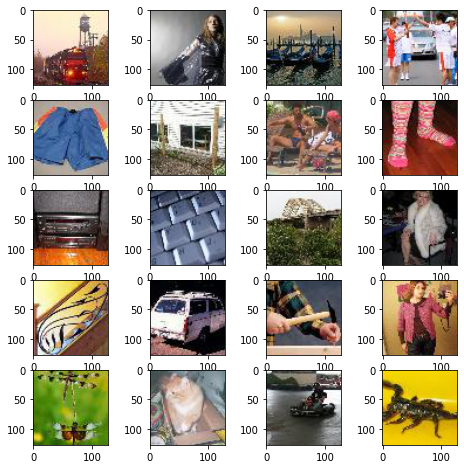

In [ ]:

# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(input_S.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(input_S[img_idx])
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers
beta = 1.0
alpha = 1.0
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * mse(s_true, s_pred)

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

    s_loss = rev_loss(s_true, s_pred)
    c_loss = beta*mse(c_true,c_pred)

    return s_loss + c_loss



# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    x = Add()([input_S,input_C])
    x = Conv2D(32, (3,3), padding="same", strides=(2,2), activation="relu")(x)
    for f in [32,64]:
        x1 = Conv2D(f, (3,3), padding="same", strides=(2,2), activation="relu")(input_S)
        x2 = Conv2D(f, (3,3), padding="same", strides=(2,2), activation="relu")(input_C)
        x =  Conv2D(f, (3,3), padding="same", strides=(1,1), activation="relu")(x)
        x = Concatenate()([x,x1,x2])
    x = Conv2D(64, (3,3), padding="same", strides=(1,1), activation="relu")(x)
    x = Conv2DTranspose(32, (3,3), padding="same", strides=(2,2), activation="relu")(x)
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))
    x = Conv2D(32, (3,3), strides=(2,2), padding="same", activation="relu")(reveal_input)
    for f in[32,64]:
      x1 = Conv2D(f, (3,3), strides=(1,1), padding="same", activation="relu")(x)
      x2 = Conv2D(f, (3,3), strides=(1,1), padding="same", activation="relu")(x1)
      x = Concatenate()([x1,x2])
    x = Conv2D(64, (3,3), padding="same", strides=(1,1), activation="relu")(x)
    x = Conv2DTranspose(32, (3,3), strides=(2,2), padding="same", activation="relu")(x)
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation="sigmoid", name='output_S')(x)
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    encoder = make_encoder(input_size)
    decoder = make_decoder(input_size)
    opt=Adam(1e-3)
    decoder.compile(optimizer=opt, loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)


    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))


    autoencoder.compile(optimizer=opt, loss=full_loss)

    return  encoder, decoder, autoencoder



In [ ]:
def train(e,lr):

  NB_EPOCHS = e
  BATCH_SIZE = 8
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  K.set_value(autoencoder_model.optimizer.lr,lr)
  K.set_value(reveal_model.optimizer.lr,lr)
  m = input_S.shape[0]
  loss_history = []
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)

      ae_loss = []
      rev_loss = []
      cover_imgs=[]
      secret_imgs=[]
      encoded_secrets=[]
      decoded_secrets=[]
      diff_ss=[]
      diff_cc=[]
      for idx in t:

          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

          C_prime = encoder_model.predict([batch_S, batch_C])
          aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                    y=np.concatenate((batch_S, batch_C),axis=3))

          ae_loss.append(aeLoss)

          revLoss = reveal_model.train_on_batch(x=C_prime,
                                                y=batch_S)
          rev_loss.append(revLoss)



          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.4f} | Loss Rev {:10.4f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))

      mean_ae_loss = np.mean(ae_loss)

      loss_history.append(mean_ae_loss)
      print(len(loss_history))
      if (epoch+1)%10==0:
        # Retrieve decoded predictions.
        decoded = autoencoder_model.predict([input_S, input_C])
        decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

        # Get absolute difference between the outputs and the expected values.
        diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

        # Configs for results display

        # Show images in gray scale
        SHOW_GRAY = False
        # Show difference bettwen predictions and ground truth.
        SHOW_DIFF = True

        # Diff enhance magnitude
        ENHANCE = 1

        # Number of secret and cover pairs to show.
        n = 6

        def rgb2gray(rgb):
            return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

        def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
            ax = plt.subplot(n_rows, n_col, idx)
            if gray:
                plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
            else:
                plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if first_row:
                plt.title(title)

        fig = plt.figure(figsize=(14, 15))
        rand_indx = [random.randint(0, 999) for x in range(n)]
        # for i, idx in enumerate(range(0, n)):
        for i, idx in enumerate(rand_indx):
            n_col = 6 if SHOW_DIFF else 4
            cover = input_C[idx]
            show_image(cover, n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
            cover_imgs.append(cover)
            #wandb.log({"Cover":wandb.Image(input_C[idx])})

            secret = input_S[idx]
            show_image(secret, n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
            secret_imgs.append(secret)
            #wandb.log({"Secret":wandb.Image(input_S[idx])})

            encoded_secret = decoded_C[idx]
            show_image(encoded_secret, n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
            encoded_secrets.append(encoded_secret)
            #wandb.log({"Encoded Secret":wandb.Image(decoded_C[idx])})

            decoded_secret = decoded_S[idx]
            show_image(decoded_secret, n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')
            decoded_secrets.append(decoded_secret)
            #wandb.log({"Decoded Cover":wandb.Image(decoded_S[idx])})


            if SHOW_DIFF:
                diff_c = np.multiply(diff_C[idx], ENHANCE)
                show_image(diff_c, n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
                diff_cc.append(diff_c)
                #wandb.log({"Diff Cover":wandb.Image(diff_C[idx])})

                diff_s = np.multiply(diff_S[idx], ENHANCE)
                show_image(diff_s, n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')
                diff_ss.append(diff_s)
                #wandb.log({"Diff Secret":wandb.Image(diff_S[idx])})

        # Now we can save it to a numpy array.
        plt.savefig('output.png')









  return encoder_model, reveal_model, autoencoder_model
  plt.plot(loss_history)

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()



Epoch 1 | Batch: 1992 of 2000. Loss AE     0.0614 | Loss Rev     0.0358: 100%|██████████| 250/250 [01:17<00:00,  3.23it/s]


1


Epoch 2 | Batch: 1992 of 2000. Loss AE     0.0135 | Loss Rev     0.0102: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s]


2


Epoch 3 | Batch: 1992 of 2000. Loss AE     0.0079 | Loss Rev     0.0058: 100%|██████████| 250/250 [00:54<00:00,  4.63it/s]


3


Epoch 4 | Batch: 1992 of 2000. Loss AE     0.0059 | Loss Rev     0.0043: 100%|██████████| 250/250 [00:53<00:00,  4.67it/s]


4


Epoch 5 | Batch: 1992 of 2000. Loss AE     0.0049 | Loss Rev     0.0035: 100%|██████████| 250/250 [00:53<00:00,  4.65it/s]


5


Epoch 6 | Batch: 1992 of 2000. Loss AE     0.0040 | Loss Rev     0.0029: 100%|██████████| 250/250 [00:54<00:00,  4.62it/s]


6


Epoch 7 | Batch: 1992 of 2000. Loss AE     0.0039 | Loss Rev     0.0028: 100%|██████████| 250/250 [00:53<00:00,  4.66it/s]


7


Epoch 8 | Batch: 1992 of 2000. Loss AE     0.0034 | Loss Rev     0.0025: 100%|██████████| 250/250 [00:53<00:00,  4.65it/s]


8


Epoch 9 | Batch: 1992 of 2000. Loss AE     0.0034 | Loss Rev     0.0025: 100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


9


Epoch 10 | Batch: 1992 of 2000. Loss AE     0.0032 | Loss Rev     0.0024: 100%|██████████| 250/250 [00:54<00:00,  4.63it/s]


10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch 11 | Batch: 1992 of 2000. Loss AE     0.0034 | Loss Rev     0.0026: 100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


11


Epoch 12 | Batch: 1992 of 2000. Loss AE     0.0030 | Loss Rev     0.0022: 100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


12


Epoch 13 | Batch: 1992 of 2000. Loss AE     0.0031 | Loss Rev     0.0024: 100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


13


Epoch 14 | Batch: 1992 of 2000. Loss AE     0.0028 | Loss Rev     0.0022: 100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


14


Epoch 15 | Batch: 1992 of 2000. Loss AE     0.0028 | Loss Rev     0.0022: 100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


15


Epoch 16 | Batch: 1992 of 2000. Loss AE     0.0029 | Loss Rev     0.0023: 100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


16


Epoch 17 | Batch: 1992 of 2000. Loss AE     0.0033 | Loss Rev     0.0025: 100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


17


Epoch 18 | Batch: 1992 of 2000. Loss AE     0.0026 | Loss Rev     0.0020: 100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


18


Epoch 19 | Batch: 1992 of 2000. Loss AE     0.0028 | Loss Rev     0.0022: 100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


19


Epoch 20 | Batch: 1992 of 2000. Loss AE     0.0027 | Loss Rev     0.0021: 100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch 21 | Batch: 1992 of 2000. Loss AE     0.0026 | Loss Rev     0.0020: 100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


21


Epoch 22 | Batch: 1992 of 2000. Loss AE     0.0028 | Loss Rev     0.0022: 100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


22


Epoch 23 | Batch: 1992 of 2000. Loss AE     0.0026 | Loss Rev     0.0020: 100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


23


Epoch 24 | Batch: 1992 of 2000. Loss AE     0.0023 | Loss Rev     0.0018: 100%|██████████| 250/250 [00:54<00:00,  4.63it/s]


24


Epoch 25 | Batch: 1992 of 2000. Loss AE     0.0026 | Loss Rev     0.0020: 100%|██████████| 250/250 [00:56<00:00,  4.45it/s]


25


Epoch 26 | Batch: 1992 of 2000. Loss AE     0.0028 | Loss Rev     0.0022: 100%|██████████| 250/250 [00:55<00:00,  4.48it/s]


26


Epoch 27 | Batch: 1992 of 2000. Loss AE     0.0023 | Loss Rev     0.0017: 100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


27


Epoch 28 | Batch: 1992 of 2000. Loss AE     0.0020 | Loss Rev     0.0015: 100%|██████████| 250/250 [00:53<00:00,  4.66it/s]


28


Epoch 29 | Batch: 1992 of 2000. Loss AE     0.0020 | Loss Rev     0.0014: 100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


29


Epoch 30 | Batch: 1992 of 2000. Loss AE     0.0015 | Loss Rev     0.0010: 100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch 31 | Batch: 1992 of 2000. Loss AE     0.0017 | Loss Rev     0.0011: 100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


31


Epoch 32 | Batch: 1992 of 2000. Loss AE     0.0013 | Loss Rev     0.0008: 100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


32


Epoch 33 | Batch: 1992 of 2000. Loss AE     0.0017 | Loss Rev     0.0012: 100%|██████████| 250/250 [00:54<00:00,  4.63it/s]


33


Epoch 34 | Batch: 1992 of 2000. Loss AE     0.0015 | Loss Rev     0.0010: 100%|██████████| 250/250 [00:54<00:00,  4.62it/s]


34


Epoch 35 | Batch: 1992 of 2000. Loss AE     0.0012 | Loss Rev     0.0008: 100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


35


Epoch 36 | Batch: 1992 of 2000. Loss AE     0.0012 | Loss Rev     0.0007: 100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


36


Epoch 37 | Batch: 1992 of 2000. Loss AE     0.0013 | Loss Rev     0.0009: 100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


37


Epoch 38 | Batch: 1992 of 2000. Loss AE     0.0011 | Loss Rev     0.0007: 100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


38


Epoch 39 | Batch: 1992 of 2000. Loss AE     0.0011 | Loss Rev     0.0007: 100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


39


Epoch 40 | Batch: 1992 of 2000. Loss AE     0.0010 | Loss Rev     0.0006: 100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Epoch 41 | Batch: 1992 of 2000. Loss AE     0.0011 | Loss Rev     0.0007: 100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


41


Epoch 42 | Batch: 1992 of 2000. Loss AE     0.0016 | Loss Rev     0.0011: 100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


42


Epoch 43 | Batch: 1992 of 2000. Loss AE     0.0012 | Loss Rev     0.0008: 100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


43


Epoch 44 | Batch: 1992 of 2000. Loss AE     0.0011 | Loss Rev     0.0007: 100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


44


Epoch 45 | Batch: 1992 of 2000. Loss AE     0.0011 | Loss Rev     0.0007: 100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


45


Epoch 46 | Batch: 1992 of 2000. Loss AE     0.0011 | Loss Rev     0.0007: 100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


46


Epoch 47 | Batch: 1992 of 2000. Loss AE     0.0009 | Loss Rev     0.0005: 100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


47


Epoch 48 | Batch: 1992 of 2000. Loss AE     0.0010 | Loss Rev     0.0006: 100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


48


Epoch 49 | Batch: 1992 of 2000. Loss AE     0.0010 | Loss Rev     0.0006: 100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


49


Epoch 50 | Batch: 1992 of 2000. Loss AE     0.0009 | Loss Rev     0.0005: 100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


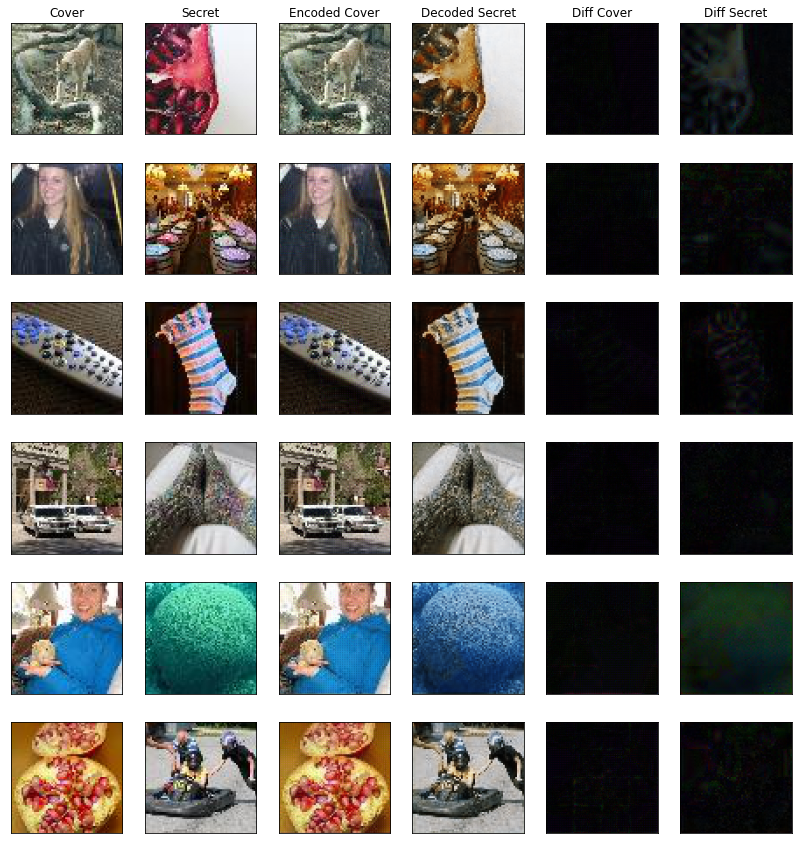

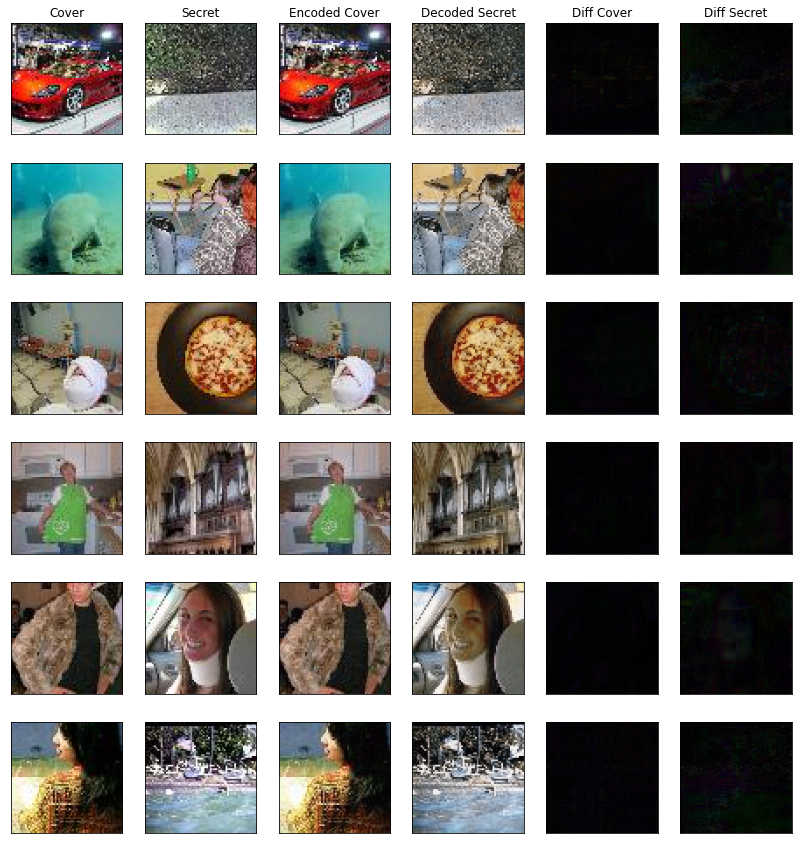

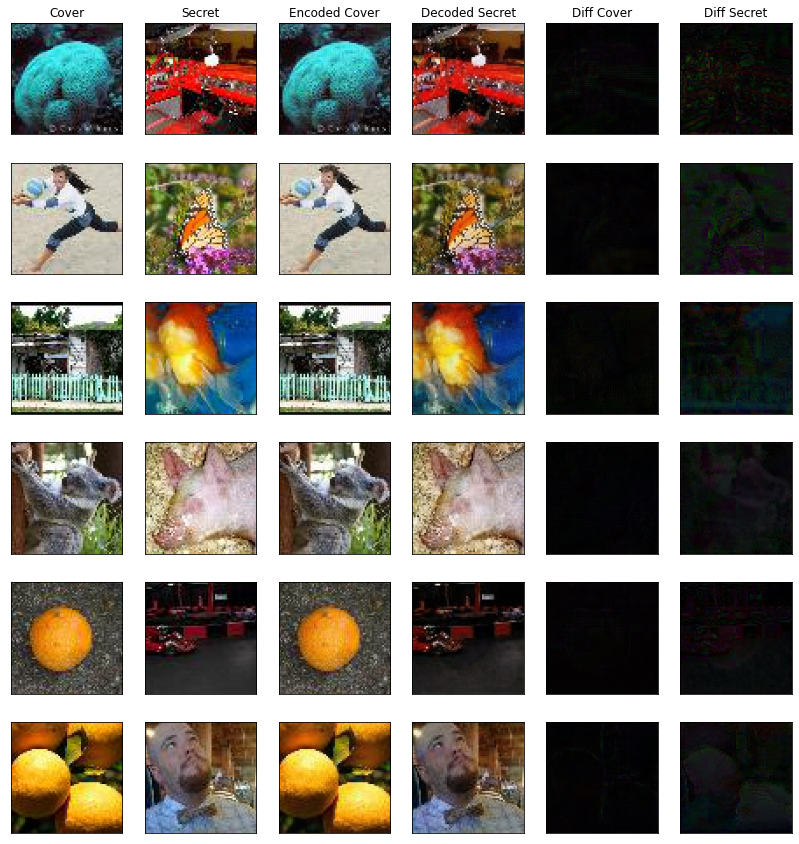

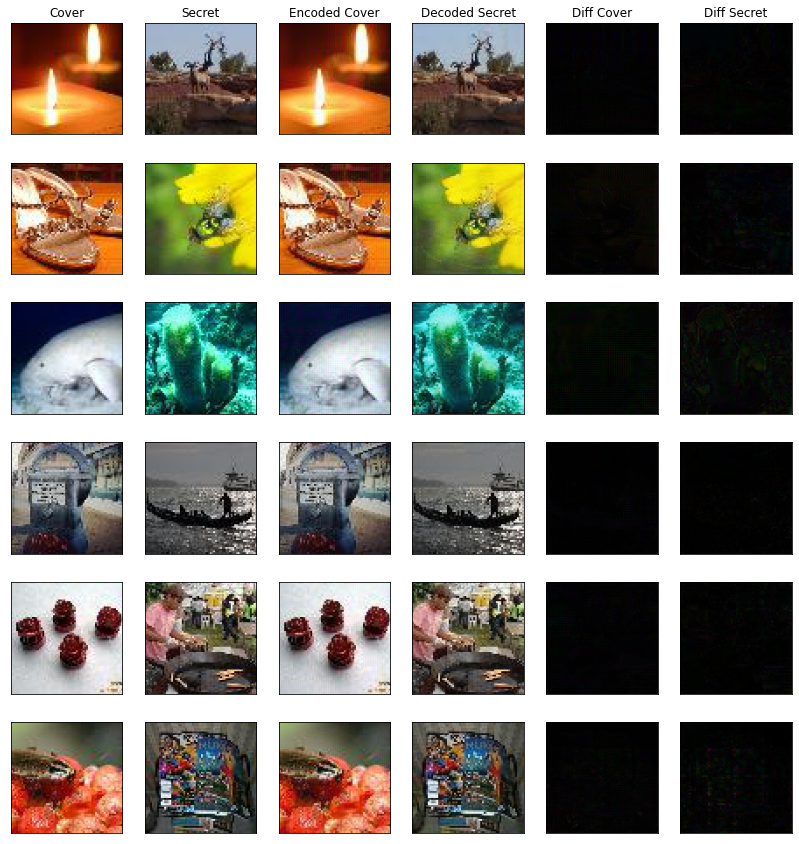

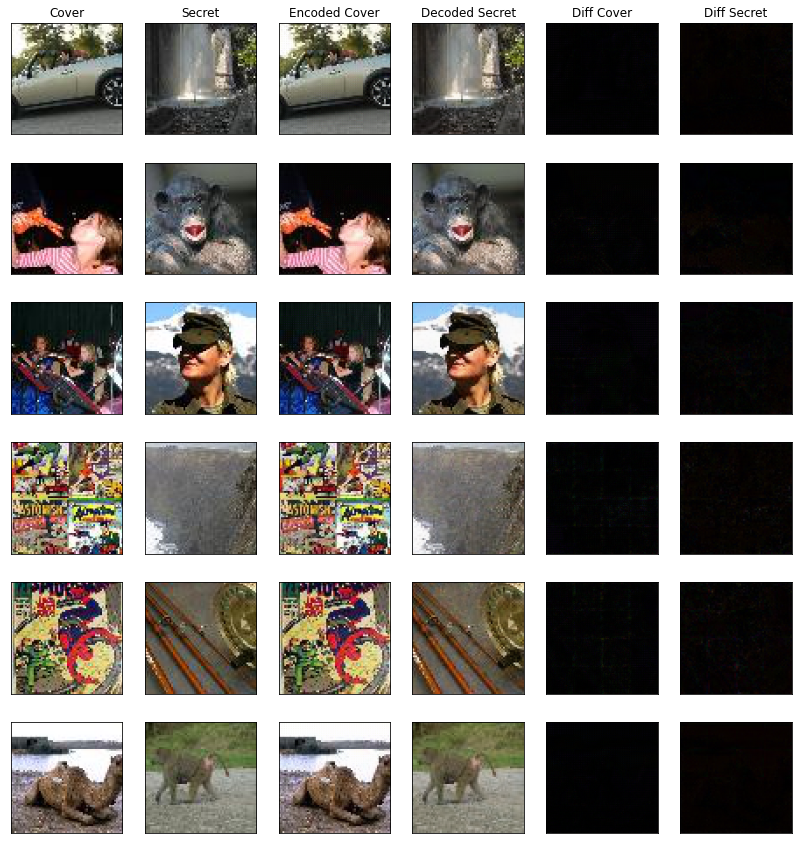

In [ ]:
encoder,decoder,autoencoder=train(50,0.0004)

In [ ]:
#autoencoder.fit(x=([input_S,input_C]),y=concatenate([input_S,input_C]),batch_size=64,epochs=50)

In [ ]:
input_S_test = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C_test = X_test[X_test.shape[0] // 2 :]

In [ ]:
C_test=encoder.predict([input_S_test,input_C_test])
S_test=decoder.predict(C_test)

In [ ]:

mae(input_C_test,C_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.013436431>

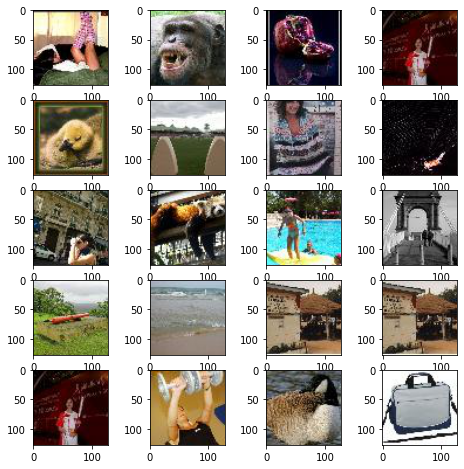

In [ ]:

# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(input_C_test.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(input_C_test[img_idx])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

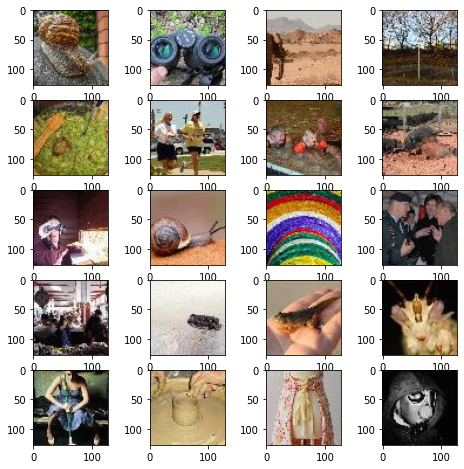

In [ ]:

# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(C_test.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(C_test[img_idx])
plt.show()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio
print(peak_signal_noise_ratio(input_C_test,C_test))

34.6790535416658


In [ ]:
from skimage.metrics import structural_similarity
print(structural_similarity(input_C_test,C_test,multichannel=True))

0.9972299523235439


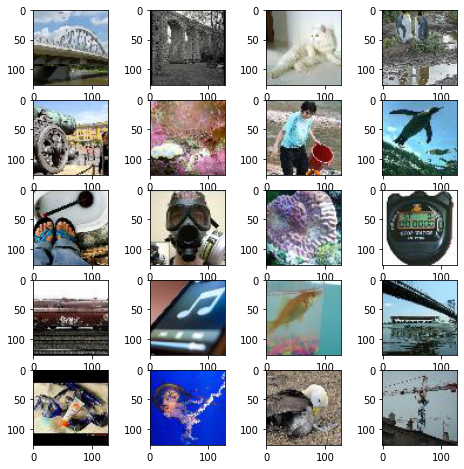

In [ ]:

# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(input_S_test.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(input_S_test[img_idx])
plt.show()

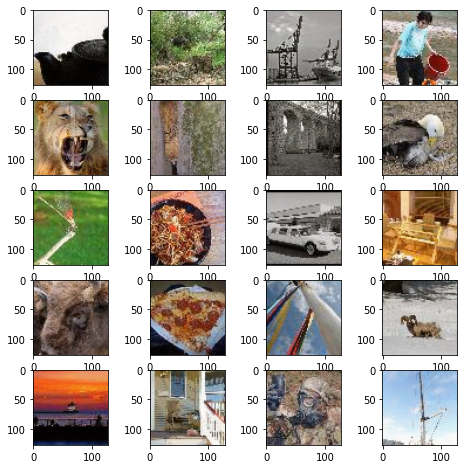

In [ ]:

# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(S_test.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(S_test[img_idx])
plt.show()

In [ ]:

mae(input_S_test,S_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.016407536>

In [ ]:
encoder.save("encoderfinal.h5")
decoder.save("decoderfinal.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
autoencoder.save("autoencoderfinal.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
from skimage.metrics import peak_signal_noise_ratio
print(peak_signal_noise_ratio(input_S_test,S_test))

33.19884967760831


In [ ]:
from skimage.metrics import structural_similarity
print(structural_similarity(input_S_test,S_test,multichannel=True))

0.9969928289547165
